#  Use Halomonas model, Measure the media impact on cell growth and on PHA production. Manipulate input media to measure cell growth
- Useful functions
- Measure the consumption of each compound, against growth
- measure Production envelope

In [1]:
from escher import Builder
from IPython.display import display
import cobra
import pandas as pd
from cobra.io import read_sbml_model, write_sbml_model, save_json_model, load_json_model
import numpy as np
from matplotlib import pyplot as plt
from cobra.flux_analysis import production_envelope
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as tri

In [ ]:
LB60_model = read_sbml_model('/Users/hellpark/Desktop/Chalmers_2_model.sbml')

In [ ]:
# gurobi alternate solver, typically better
model.solver = 'cplex'

## Useful functions for testing

In [580]:
def set_yeast_extraction(model,ub=1000,lb=-1000):
    # given the evidence that TD01 strain can growth wihout supplyment of amino acids, 
    # the strain should be able to produce 20 amino acids by itself.
    # Block the uptake of 20 amino acids
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c','L-LACTATE','CPD-15990', 'ADENINE'
                   
                  ]
    for met_id in amino_acids:
        exg_rxn = model.reactions.get_by_id('Exchange_'+met_id.replace('_c',''))
        exg_rxn.upper_bound = ub
        exg_rxn.lower_bound = lb
        
def set_bound(model,rxn_id,lb=None,ub=None,eq=None):
    rxn = model.reactions.get_by_id(rxn_id)
    if lb is not None: rxn.lower_bound = lb
    if ub is not None: rxn.upper_bound = ub
    if eq is not None: 
        rxn.lower_bound = eq
        rxn.upper_bound = eq


In [401]:
def test_PHA_production(model):
    pha_sink = cobra.Reaction('pha_sink')
    pha_sink.add_metabolites({model.metabolites.get_by_id('PHA_c'):-1})
    
    with model:
        model.add_reactions([pha_sink]) 
        set_yeast_extraction(model,lb=0,ub=0)
        model.objective = 'pha_sink'
        model.objective_direction = 'max'
        s1 = model.optimize()

    return s1   

In [ ]:
def test_urea_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,100,5)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
        for glc in glcs:
            set_bound(model,'Exchange_UREA',ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value/1000*86.5)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('Urea mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.81, .65),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/plots.pdf")
        plt.show()

In [ ]:
def test_phosphate_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,30,1)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
        for glc in glcs:
            set_bound(model,'Exchange_CPD-16459',ub=glc)
            set_bound(model,'Exchange_K+',ub=glc)
            set_yeast_extraction(model,lb=-1000,ub=1000)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            if s3.objective_value is None:
                s3.objective_value = .000001
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('Phosphate mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.75, .62),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/phosphate.pdf")
        plt.show()

In [ ]:
def test_acetate(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(-700,1000,50)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
        for glc in glcs:
            set_bound(model,'Exchange_ACET',ub=glc)
            set_yeast_extraction(model,lb=-1000,ub=1000)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            if s3.objective_value is None:
                s3.objective_value = .000001
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('Acetate Production',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.75, .42),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/acetate.pdf")
        plt.show()        

def test_glucose_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,1000,50)
        set_yeast_extraction(model,lb=0,ub=0)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
       # set_bound(model,'Exchange_Glucopyranose',ub=20)
        for glc in glcs:
            set_bound(model,'Exchange_Glucopyranose',ub=glc)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            if s3.objective_value is None:
                s3.objective_value = .000001
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('Glucose mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.76, .7),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/glucose.pdf")
        plt.show()

In [ ]:
def test_sulfate_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,.05,.005)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
        for glc in glcs:
            set_bound(model,'Exchange_MG+2',ub=glc)
            set_bound(model,'Exchange_HSO4',ub=glc)
            set_yeast_extraction(model,lb=0,ub=1)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            set_yeast_extraction(model,lb=0,ub=.5)
            s3 = test_PHA_production(model)
            if s3.objective_value is None:
                s3.objective_value = .000001
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('MgSO  mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.65, .52),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/sulfate.pdf")
        plt.show()
        
def test_o_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,75,1)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        for glc in glcs:
            set_bound(model,'Exchange_OXYGEN-MOLECULE',lb=glc,ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
          #  set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('O_2 mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.65, .42),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/oxygen.pdf")
        plt.show()

In [ ]:
def test_yeast(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,10,1)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=1000)
        for glc in glcs:
            set_yeast_extraction(model,ub=glc)#,ub=glc)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            if s3.objective_value is None:
                s3.objective_value = .000001
            rgs2.append(s3.objective_value/1000*86.5)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('Yeast mmol(gDW*h)$^{-1}$',size=12)
        plt.rcParams["font.family"] = "arial"
        #ax2.set_ylim([0,2])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.7, .45),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/plots.pdf")
        plt.show()     

In [ ]:
def test_NMAM(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(6.86,30,1)
        set_bound(model,'Exchange_Glucopyranose',ub=1000)
        for glc in glcs:
            set_bound(model,'NGAM',lb=glc,ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
          #  set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*259.0/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots(figsize=(4,3))
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, color='royalblue',linestyle='dashed', linewidth=2.5)
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=12)
        ax2.set_ylabel('PHA g(gDW*h)$^{-1}$',size=12)
        ax1.set_xlabel('NGAM',size=12)
        plt.rcParams["font.family"] = "arial"
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA'], bbox_to_anchor=(0.65, .42),frameon='False')
        #ax2.set_ylim(ymin=0)
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/ngam.pdf")
        plt.show()

In [ ]:
def test_urea_3(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,16,1)
        set_bound(model,'Exchange_Glucopyranose',ub=20)
        for glc in glcs:
            set_bound(model,'Exchange_UREA',ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
           # set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots()
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, linestyle='dashed')
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='orange', linestyle='solid')
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=18)
        ax2.set_ylabel('PHA (g/(gDW*h))',size=18)
        ax1.set_xlabel('Urea (mmol/(gDW*h)',size=18)
        ax2.set_ylim([0,100])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA%'], bbox_to_anchor=(0.6, .92),frameon='False')
        ax2.get_xaxis().get_major_formatter().set_scientific(False)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)

        fig.tight_layout()
        plt.show()
        print(s3)

### Manipulate boundary equations
Measure the consumption of each compound, against growth

In [181]:
model.reactions.get_by_id('Exchange_OXYGEN-MOLECULE').lower_bound=0
model.reactions.get_by_id('Exchange_OXYGEN-MOLECULE').upper_bound=100
model.reactions.get_by_id('Exchange_Glucopyranose').lower_bound=1
model.reactions.get_by_id('Exchange_Glucopyranose').upper_bound=40
model.reactions.get_by_id('Exchange_ACET').lower_bound=0
model.reactions.get_by_id('Exchange_ACET').upper_bound=1000

/Users/hellpark/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


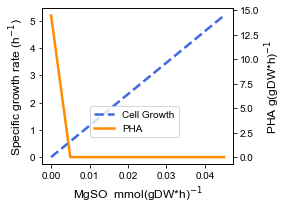

In [407]:
#test_urea_2(model)
#test_urea_3(model)
#test_yeast(model)
#test_phosphate_2(model)



test_sulfate_2(model)
#test_o_2(model)
#test_glucose_2(model)
#test_acetate(model)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


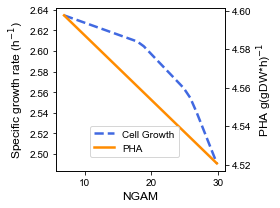

In [350]:
test_NMAM(model)

## change model, adjust by adding a little more glucose

In [41]:
with model:
    rgs = []
    rgs2 = []
    glcs = np.arange(0,16,1)
    set_bound(model,'Exchange_Glucopyranose',ub=20)
    for glc in glcs:
        set_bound(model,'Exchange_UREA',ub=glc)
        set_yeast_extraction(model,lb=0,ub=0)
        s1 = model.optimize()
        rgs.append(s1.objective_value)
            
        set_bound(model,'Biomass_v1')
        s3 = test_PHA_production(model)
        print(s3.get_primal_by_id('PHA_synthetase'))
        rgs2.append(s3.objective_value)
        set_bound(model,'Biomass_v1',lb=0,ub=1000)

90.94461538461539
90.94461538461536
90.94461538461536
90.94461538461536
90.94461538461536
90.94461538461542
90.94461538461536
90.9446153846154
90.9446153846154
90.94461538461516
90.94461538461536
90.94461538461535
90.94461538461537
90.94461538461543
90.94461538461539
90.94461538461539


# Measure Production envelope

In [5]:
from cobra.flux_analysis import production_envelope
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as tri

In [562]:
#set_bound(model, 'Exchange_UREA',ub=20,lb=-20)
set_yeast_extraction(model,ub=0,lb=0)

In [603]:
with model:
    newconstraint = model.problem.Objective(
        .5*model.reactions.Biomass_v1.flux_expression - (1-.5)*model.reactions.PHA_secretion.flux_expression)
    model.objective=model.reactions.Biomass_v1
    a=10
    set_bound(model,'Exchange_OXYGEN-MOLECULE',lb=,ub=20)
    set_bound(model,'Exchange_Glucopyranose',lb=5,ub=5)
    s1 = model.optimize()
    print(s1.objective_value)

0.4588769768377048


In [620]:
def test_o_2_glucose_noproductionenv(model, a, swapped=True):
    with model:
        rgs = pd.DataFrame(columns = ['x','y','z'])
        i=0
        glcs = np.arange(0,30,1)
        glcs2 = np.arange(0,10,1)
        set_yeast_extraction(model,lb=0,ub=0)
        
        newconstraint = model.problem.Objective(
        a*model.reactions.Biomass_v1.flux_expression + (1-a)*model.reactions.PHA_secretion.flux_expression)
        model.objective=newconstraint
        
        for glc in glcs:
            set_bound(model,'Exchange_OXYGEN-MOLECULE',lb=glc,ub=glc)
            for glc2 in glcs2:
                set_bound(model,'Exchange_Glucopyranose',lb=glc2,ub=glc2)
                s1 = model.optimize()
                rgs.at[i,'x']=glc
                rgs.at[i,'y']=glc2
                rgs.at[i,'z']=s1.objective_value
                i=i+1
                #rgs.append([glc,glc2,s1.objective_value])
       # print(rgs)
            
          #  set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            #s3 = test_PHA_production(model)
            #rgs2.append(s3.objective_value*259.0/10000)
            #set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
        # Make data.
        if swapped:
            X = np.array(rgs['x'],dtype=float)
            Y = np.array(rgs['y'],dtype=float)
        else:
            Y = np.array(rgs['x'],dtype=float)
            X = np.array(rgs['y'],dtype=float)
     #   X, Y = np.meshgrid(X, Y)
        Z = np.array(rgs['z'],dtype=float)
        Zmask = np.isfinite(Z)
      #  print(X)
      #  print(Y)
      #  print(np.asarray(Z).shape)

        
        surf = ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.Oranges,
                                antialiased=False, linewidth=0)
        # Customize the axis.
        ax.set_zlim(0, max(Z))
        if swapped:
            ax.set_xlabel('$O\u2082 -(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$Glucose-(mmol/(gDW*h)$',fontsize=12)
        else:
            ax.set_xlabel('$Glucose-(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$O\u2082 -(mmol/(gDW*h)$',fontsize=12)
        ax.set_zlabel('$Flux-(mmol/(gDW*h)$', fontsize=12, rotation=60)
        ax.zaxis.set_major_formatter('{x:.1f}')
        #ax.set_xlim(xmin=1)

        ax.set_facecolor('white') 
        ax.grid(False) 
        
        b=1-a
        plt.rcParams["font.family"] = "arial"
        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=.5, aspect=10,orientation='horizontal')
        plt.title('Objective = Maximize '+f'{a:.1f}'+'*Biomass+'+f'{b:.1f}'+'*PHA',fontsize=13)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/glucoseo22_4.pdf")
        plt.show()

/Users/hellpark/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


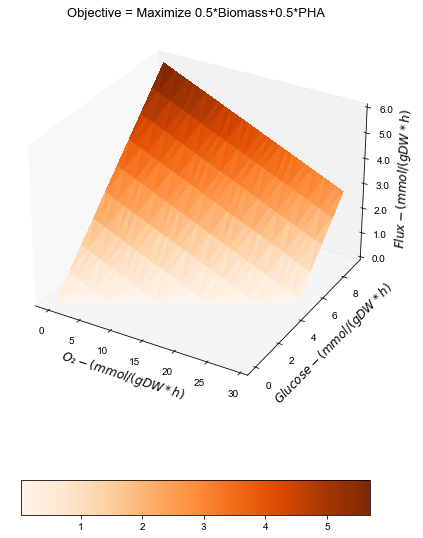

In [622]:
test_o_2_glucose_noproductionenv(model, .5, swapped=True)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


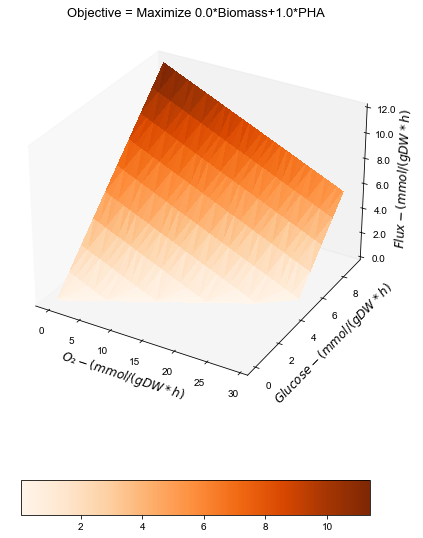

In [621]:
test_o_2_glucose_noproductionenv(model, 0.0, swapped=True)

need to set *10 and to change bounds 1->3

/Users/hellpark/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


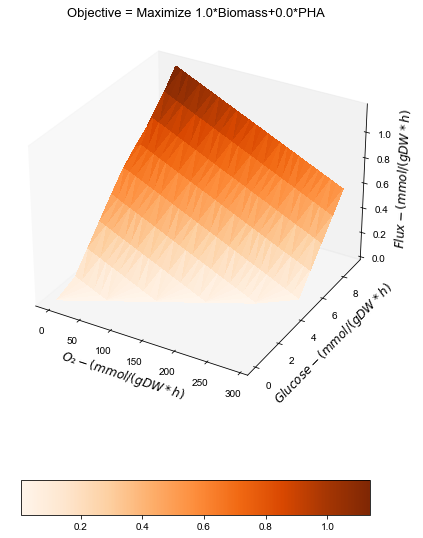

In [619]:
test_o_2_glucose_noproductionenv(model, 1.0, swapped=True)

In [538]:
def o2_glucose_impact(model,a,swapped=True):
    
    newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0.001)
        
    with model:
        model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['Exchange_Glucopyranose','Exchange_OXYGEN-MOLECULE'],objective='PHA_secretion')

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
        # Make data.
        if swapped:
            X = prod_env['Exchange_OXYGEN-MOLECULE']
            Y = prod_env['Exchange_Glucopyranose']
        else:
            Y = prod_env['Exchange_OXYGEN-MOLECULE']
            X = prod_env['Exchange_Glucopyranose']
        Zmask = np.isfinite(prod_env['flux_maximum'])
        Z = prod_env['flux_maximum']/1000*259
        print(X)
        print(Y)
        print(Z.shape)

        # Plot the surface.
        surf = ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.Oranges,
                                antialiased=False,linewidth=0,vmin=0,vmax=max(Z))
        # Customize the axis.
        ax.set_zlim(0, max(Z))
        if swapped:
            ax.set_xlabel('$O\u2082 -(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$Glucose-(mmol/(gDW*h)$',fontsize=12)
        else:
            ax.set_xlabel('$Glucose-(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$O\u2082 -(mmol/(gDW*h)$',fontsize=12)
        ax.set_zlabel('$PHA-(g/(gDW*h)$', fontsize=12, rotation=60)
        ax.zaxis.set_major_formatter('{x:.3f}')
        #ax.set_xlim(xmin=1)

        ax.set_facecolor('white') 
        ax.grid(False) 
        
        b=1-a
        plt.rcParams["font.family"] = "arial"
        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=.5, aspect=10,orientation='horizontal')
        plt.title('Objective=Maximize PHA\n\nConstraint: '+f'{a:.1f}'+'*Biomass+'+f'{b:.1f}'+'*PHA',fontsize=13)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/glucoseo22.pdf")
        plt.show()

In [345]:
def o2_NGAM_impact(model,a,swapped=True):
    
    newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
        
    with model:
        model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['NGAM','Exchange_Glucopyranose'],objective='Biomass_v1')

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
        # Make data.
        if swapped:
            X = prod_env['Exchange_Glucopyranose']
            Y = -prod_env['NGAM']
        else:
            Y = prod_env['Exchange_Glucopyranose']
            X = -prod_env['NGAM']
        Zmask = np.isfinite(prod_env['flux_maximum'])
        Z = prod_env['flux_maximum']/1000*259

        # Plot the surface.
        surf = ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.Oranges,
                                antialiased=False,linewidth=0,vmin=0,vmax=max(Z))
        # Customize the axis.
        ax.set_zlim(0, max(Z))
        if swapped:
            ax.set_xlabel('$Glucose -(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$NGAM-(mmol/(gDW*h)$',fontsize=12)
        else:
            ax.set_xlabel('$NGAM-(mmol/(gDW*h)$', fontsize=12, rotation=150)
            ax.set_ylabel('$Glucose -(mmol/(gDW*h)$',fontsize=12)
        ax.set_zlabel('$Biomass-(g/(gDW*h)$', fontsize=12, rotation=60)
        ax.zaxis.set_major_formatter('{x:.3f}')
        #ax.set_xlim(xmin=1)

        ax.set_facecolor('white') 
        ax.grid(False) 
        
        b=1-a
        plt.rcParams["font.family"] = "arial"
        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=.5, aspect=10,orientation='horizontal')
        plt.title('Objective=Maximize PHA\n\nConstraint: '+f'{a:.2f}'+'*Biomass+'+f'{b:.2f}'+'*PHA',fontsize=13)
        fig.tight_layout()
        plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/ngambiomass.pdf")
        plt.show()

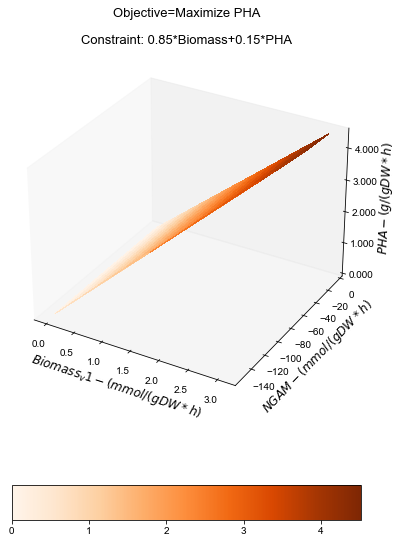

In [339]:
o2_NGAM_impact(model,.85,True)

In [9]:
def PHA_biomass_glucose_impact(model,a,swapped=True):
    
   # newconstraint = model.problem.Constraint(
    #    a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
     #   lb=0, ub=0)
        
    with model:
      #  model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['Exchange_UREA','Biomass_v1'],objective='PHA_secretion')

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
        # Make data.
        if swapped:
            X = -prod_env['Exchange_UREA']
            Y = prod_env['Biomass_v1']
        else:
            Y = -prod_env['Exchange_UREA']
            X = prod_env['Biomass_v1']
        Zmask = np.isfinite(prod_env['flux_maximum'])
        Z = prod_env['flux_maximum']

        # Plot the surface.
        surf = ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.rainbow,
                                antialiased=False,linewidth=0,vmin=0)
        # Customize the axis.
       # ax.set_zlim(0, max(prod_env['flux_maximum']))
        if swapped:
            ax.set_xlabel('$Urea (mmol/(gDW*h))$', fontsize=12, rotation=150)
            ax.set_ylabel('$Biomass$',fontsize=12)
        else:
            ax.set_xlabel('$Biomass$', fontsize=12, rotation=150)
            ax.set_ylabel('$Urea (mmol/(gDW*h))$',fontsize=12)
        ax.set_zlabel('$Flux (mmol/(gDW*h)$', fontsize=12, rotation=60)
        ax.zaxis.set_major_formatter('{x:.1f}')
        #ax.set_xlim(xmin=1)

        ax.set_facecolor('white') 
        ax.grid(False) 


        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=.5, aspect=10,orientation='horizontal')
        plt.title('Constraint: '+str(a)+'*Biomass+'+str(((1-a)))+'*PHA\nObjective=Maximize PHA',fontsize=20)

        plt.show()

In [10]:
set_bound(model,'Exchange_UREA',lb=0,ub=20)
set_bound(model,'Exchange_Glucopyranose',lb=0,ub=20)
set_yeast_extraction(model,ub=1,lb=-1)

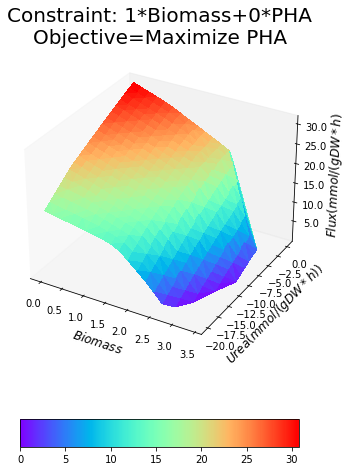

In [11]:
PHA_biomass_glucose_impact(model,1,False)

In [ ]:
import matplotlib.animation as animation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))

newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - b*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
        
    with model:
        model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['Exchange_Glucopyranose','Exchange_OXYGEN-MOLECULE'],objective='PHA_secretion')
        
def 

def animate(a):
    newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
    X = prod_env['Exchange_OXYGEN-MOLECULE']
    Y = prod_env['Exchange_Glucopyranose']
    Zmask = np.isfinite(prod_env['flux_maximum'])
    Z = prod_env['flux_maximum']
    ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.rainbow,
                    antialiased=False,linewidth=0,vmin=0,vmax=max(prod_env['flux_maximum']))
    return ax
    
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,